In [1]:
%reload_ext autoreload
%load_ext jupyter_black
%autoreload 2

import pandas as pd
import rioxarray
import xarray as xr
from netCDF4 import Dataset
import geopandas

import dask.dataframe as dd
import dask_geopandas as dg

from heatwaves.weather import *


In [2]:
import bokeh
from bokeh.layouts import *
from bokeh.models import *
import matplotlib as mpl

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span

# Understanding Impacts of Excess Heat in Filipino cities

The Project Development Objective is to empower urban Philippines Local Government Units (LGUs) to take preventative and real-time action to mitigate the impacts of heatwaves through provision of more timely and granular data products that reveal localized occurrences of heatwaves and their impacts on human health and urban economies.

Urban heatwaves have cascading impacts on the economies and well-being of people, including heat-induced hospitalizations, power-grid failure, declines in labor productivity, shortened school days, and others. Unless the impacts of heatwaves are mitigated, Filipino cities, with their high population density, will struggle to meet their full economic potential and ensure the wellbeing of their people. 

Until now, cities have been challenged to address heatwaves, because the data and expertise needed to mitigate impacts are typically scattered across many departments. To overcome this barrier, as part of the World Bank’s Technical Deep Dive on Urban Heat (April 24-28, 2023), Filipino authorities have requested support on better measurement of urban heatwaves and their impacts. To meet this demand-driven request, the project team would facilitate access to heat risk and vulnerability information for the most populous cities in the three regions of the Philippines. Through this public data good, urban governments will be able to identify investments and policy interventions that build resilience at a community level and support scaling up the resilience of the city. The knowledge product will be validated through local data collection and stakeholder participation to ensure inclusive design and participation.

In the Philippines, more than 40 percent of the population lives in cities, and many of these cities are at high risk of experiencing heatwaves.Its position as part of Southeast Asia, with high temperatures and humidity already being the norm, and the 7641 islands that make up the country are especially susceptible to climate change. Challenges in exposition, vulnerability, and adaptability to climate made the Philippines become the country with highest extreme weather disaster-related risk in the world according to the 2022 World Risk Report. Additionally, rapid urbanization is expected to continue as “drought and low farm productivity” drive migrants into cities. The consequences of heatwaves to these residents will be profound, and call for new methods to better understand their behaviors and propose better mitigation strategies. This intersects with the high inequality found in Filipino cities: in the first semester of 2021, driven by the Covid-19 pandemic, 23.7% of the country’s overall population was considered poor. Studies have shown strong correlation between poverty and vulnerability to heatwaves, and low-income housing has poor thermal performance and high thermal discomfort levels across the globe. Even without taking into consideration socioeconomic status, a vast majority of Filipinos experience heat stress severely (as self-reported), and this increases with population density.

The serious consequences are already being felt, with recent months showcasing extreme temperatures. In April 2023, for example, dangerous heat was observed throughout the country.

In this notebook, we visualize the areas within Filipino cities that are adversely impacted by heat using multiple data sources, and try to understand some of the aspects that have led to this upending crisis.

Read the shapefiles for Philippines

In [3]:
PHILIPPINES  = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_exclude_adm3/phl_admbnda_adm2_psa_namria_20200529.shp')
MANILA = PHILIPPINES[PHILIPPINES['ADM2_EN'].isin(['NCR, City of Manila, First District', 'NCR, Second District', 'NCR, Third District', 'NCR, Fourth District'])]
PHILIPPINES_ADM3 = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.shp')
DAVAO = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Davao City'])]
ZAMBOANGA = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Zamboanga City'])]
CEBU = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Cebu City'])]
PHILIPPINES_ADM1= geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_exclude_adm3/phl_admbnda_adm1_psa_namria_20200529.shp')

## Population of Philippines

The data for population is taken from [Meta High Resolution Population Maps](https://data.humdata.org/dataset/philippines-high-resolution-population-density-maps-demographic-estimates?)

Read population data for the Philippines

In [6]:
#PHL_POP_ADM1 = geopandas.read_file('../../data/population/philippines_population_adm1.geojson')
#PHL_POP_ADM2 = geopandas.read_file('../../data/population/philippines_population_adm2.geojson')

Calculate population aggregated to different admin regions

In [7]:
#population_adm1 = PHILIPPINES_ADM1.sjoin(population_gdf)
#population_adm2 = PHILIPPINES.sjoin(population_gdf)
#population_adm3 = PHILIPPINES_ADM3.sjoin(population_gdf)


In [7]:
population_adm1 = population_adm1[['ADM1_EN', 'phl_general_2020']].groupby(['ADM1_EN']).sum().reset_index()
# population_adm2 = population_adm2[['ADM2_EN', 'phl_general_2020']].groupby(['ADM2_EN', 'ADM1_EN']).sum().reset_index()
# population_adm3 = population_adm3[['ADM3_EN', 'phl_general_2020']].groupby(['ADM3_EN', 'ADM2_EN', 'ADM1_EN']).sum().reset_index()

### Population of the Philippines as of 2020

[]

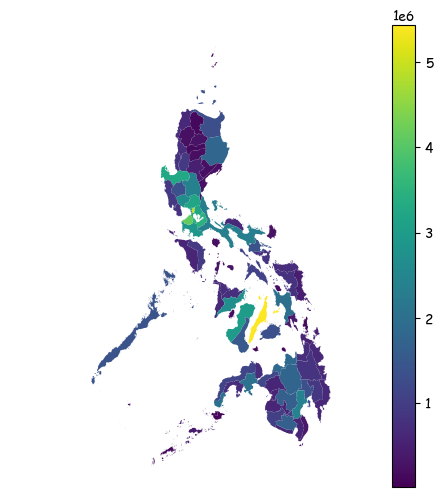

In [178]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(36,6))
plt.rcParams["font.family"] = "cursive"

PHILIPPINES_ADM1.plot(column='phl_general_2020', legend = False, ax=ax[0])
PHILIPPINES_ADM2.plot(column='phl_general_2020', legend = False, ax=ax[1])
PHILIPPINES_ADM3.plot(column='phl_general_2020', legend = True, ax=ax[2])

for i in range(0,2):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

    ax[i].set_xticks([])
    ax[i].set_yticks([])

**Observation**
- At the Admin 3 level, Cebu looks more populated than Manila. However, Manila comprises of 4 admin 3 regions making it a lot more densely populated

## Measure historical heatwaves and heat index trends in the Philippines using NASA GLDAS data

Heatwaves are generally understood to be the combination of extreme temperatures over multiple days. A more quantitative definition, however, is very contested and there is no definitive answer, with different characterizations being useful at different times or contexts.

1. **Heat Wave Duration Index**: HWDI or heatwave duration index shows the number of heatwaves according to multiple modifications of the WMO definitions of heatwaves. Here, a heatwave is defined as 2 consecutive days where the mean temperature is more than 5 degrees of the mean temperature of the baseline from 1948 to 2014.
2. **Heat Index**: Heat index aka apparent temperature is based on work carried out by Robert G. Steadman in 1979 ("An Assessment of Sultriness, Parts I and II") where he discussed factors that would impact how hot a person would feel under certain conditions. It incorporates 21 parameters and assumptions: body mass (147.7 lbs), height (5'7"), actively walking (3.1 mph), clothing (pants and short sleeve shirt), heat tolerance, in the shade, etc. This formula became the "heat index". It is the traditional measurement of heat stress due to high temperatures and high humidity.
*Heat index is calculated for shady areas*
    The inputs to this are - temperature, relative humidity
    Equation:
    Heat Index = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
    * T = ambient dry temperature (in Fahrenheit)
    * R = relative humidity (percentage)

In [4]:
ds_mean2_gldas=xr.open_mfdataset("../../data/gldas/ymean2/wld_cli_*.nc4", parallel = True)

In [6]:
def add_city_name(df, city_name):
    df['city'] = city_name

    return df

In [7]:
manila_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, MANILA).to_dataframe().reset_index(), 'Manila')
davao_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, DAVAO).to_dataframe().reset_index(), 'Davao')
zamboanga_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, ZAMBOANGA).to_dataframe().reset_index(), 'Zamboanga')
cebu_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, CEBU).to_dataframe().reset_index(), 'Cebu')

phl_cities_hwdi_mean2 = pd.concat([manila_hwdi_mean2, zamboanga_hwdi_mean2, davao_hwdi_mean2, cebu_hwdi_mean2])

In [35]:
output_notebook()
show(get_line_plot(phl_cities_hwdi_mean2, measure = 'heat_waves_per_time_period', title = 'Heatwaves per time period', subtitle = 'heatwave is defined as 2 consecutive days where the mean temperature is more than 5 degrees of the mean temperature of the baseline from 1948 to 2014', source= 'GLDAS data with analysis from the Data Lab, World Bank'))

Loading BokehJS ...

In [8]:
manila_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/manila_heat_index_daily.csv'), 'Manila')
davao_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/davao_heat_index_daily.csv'), 'Davao')
zamboanga_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/zamboanga_heat_index_daily.csv'), 'Zamboanga')
cebu_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/cebu_heat_index_daily.csv'), 'Cebu')

In [22]:
phl_cities_heatindex = pd.concat([manila_heatindex, zamboanga_heatindex, davao_heatindex, cebu_heatindex])

In [36]:
phl_cities_heatindex_year = phl_cities_heatindex[['city', 'time', 'heat_index']].groupby([pd.Grouper(key='time', freq='Y'), 'city']).agg({'mean', 'max', 'min'}).reset_index()
phl_cities_heatindex_year.set_index(['time', 'city'], inplace=True)
phl_cities_heatindex_year.columns = phl_cities_heatindex_year.columns.droplevel(0)
phl_cities_heatindex_year.reset_index(inplace=True)

In [23]:
phl_cities_heatindex['time'] = phl_cities_heatindex['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [38]:
output_notebook()
from bokeh.models import Panel
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

for value in list(['min', 'max', 'mean']):

    tabs.append(Panel(child=get_line_plot(phl_cities_heatindex_year.reset_index(), f"Heat Index Per Year", "Source: GLDAS NASA - Heat index calculated using NWS (2011)",measure=value,  subtitle = 'Heat index is calculated using both temperature and relative humidity'), title=value.capitalize()
                ))

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

## Comparing heatwaves and heat index from different sources for April 2023

1. Tomorrow.io
2. Heat Index from PAGASA: Philippine Atmospheric, Geophysical and Astronomical Services Administration (PAGASA).

In [9]:
manilaport_heatindex_pagasa = add_city_name(geopandas.read_file('../../data/pasay/pag_port.geojson'), 'Manila Port')
manilaquezon_heatindex_pagasa = add_city_name(geopandas.read_file('../../data/pasay/pag_quezon.geojson'), 'Quezon')
manilapasay_heatindex_pagasa = add_city_name(geopandas.read_file('../../data/pasay/pag_pasay.geojson'), 'Pasay')

manilaport_heatindex_pagasa_max = add_city_name(geopandas.read_file('../../data/pasay/pag_port_max.geojson'), 'Manila Port')
manilaquezon_heatindex_pagasa_max = add_city_name(geopandas.read_file('../../data/pasay/pag_quezon_max.geojson'), 'Quezon')
manilapasay_heatindex_pagasa_max = add_city_name(geopandas.read_file('../../data/pasay/pag_pasay_max.geojson'), 'Pasay')

Date manipulation

In [18]:
from datetime import datetime
manilaport_heatindex_pagasa_max['Date'] = manilaport_heatindex_pagasa_max['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
manilaquezon_heatindex_pagasa_max['Date'] = pd.to_datetime(manilaquezon_heatindex_pagasa_max[['Year', 'Month', 'Day']])

Combine the data from different cities into one dataframe

In [11]:
phl_cities_heatindex_pagasa = pd.concat([manilaport_heatindex_pagasa, manilaquezon_heatindex_pagasa, manilapasay_heatindex_pagasa])
phl_cities_heatindex_pagasa_max = pd.concat([manilaport_heatindex_pagasa_max, manilaquezon_heatindex_pagasa_max, manilapasay_heatindex_pagasa_max])

In [20]:
phl_cities_heatindex_pagasa_max.rename(columns = {'Date':'time'}, inplace=True)
phl_cities_heatindex_pagasa.rename(columns = {'Date':'time'}, inplace=True)

In [52]:
manila_heatindex_tomorrowio_mean = pd.read_csv('../../data/tomorrow.io/manila_april2023_mean_heat_index.csv')
manila_heatindex_tomorrowio_max= pd.read_csv('../../data/tomorrow.io/manila_april2023_max_heat_index.csv')

In [53]:
manila_heatindex_tomorrowio_mean['startTime'] = manila_heatindex_tomorrowio_mean['startTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
manila_heatindex_tomorrowio_max['startTime'] = manila_heatindex_tomorrowio_max['startTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))

In [54]:
manila_heatindex_tomorrowio_mean = manila_heatindex_tomorrowio_mean.groupby(['startTime']).mean()[['heat_index_C']].reset_index()
manila_heatindex_tomorrowio_max = manila_heatindex_tomorrowio_max.groupby(['startTime']).mean()[['heat_index_C']].reset_index()

In [55]:
manila_heatindex_tomorrowio_mean['city'] = 'Manila'
manila_heatindex_tomorrowio_max['city'] = 'Manila'

In [56]:
manila_heatindex_tomorrowio_mean.rename(columns = {'startTime':'time', 'heat_index_C':'Average Heat Index'}, inplace=True)
manila_heatindex_tomorrowio_max.rename(columns = {'startTime':'time', 'heat_index_C':'Maximum Heat Index'}, inplace=True)

In [57]:
output_notebook()
show(get_line_plot(pd.concat([manila_heatindex_tomorrowio_max, phl_cities_heatindex_pagasa_max]), measure = 'Maximum Heat Index', title = 'Max Heat Index', subtitle = 'heat index calculated from Tomorrow.io', source= 'Tomorrow.io'))

Loading BokehJS ...

c:\Users\sahit\anaconda3\envs\heatwaves\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [58]:
output_notebook()
show(get_line_plot(pd.concat([manila_heatindex_tomorrowio_mean, phl_cities_heatindex_pagasa]), measure = 'Average Heat Index', title = 'Mean Heat Index', subtitle = 'heat index calculated from Tomorrow.io', source= 'Tomorrow.io'))

Loading BokehJS ...

c:\Users\sahit\anaconda3\envs\heatwaves\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


### Observations

1. The mean heat index from PAGSA and tomorrow.io aligns almost exactly but the max values are far apart from each other

### Plotting heat index at 5km grids 

By plotting the heat index on resolution 7 hex grids, we noticed that there is difference in temperatures in different regions of Manila

<iframe width="100%" height="500px" src="https://studio.foursquare.com/public/0b43c93d-427b-4534-8d47-8dcf0676b0f2/embed" frameborder="0" allowfullscreen></iframe>

### Next Steps

- Compare Heat Index in Manila with other cities
- Analyse change in visitations to Points of Interest with changing heat index (using a methodology similar to that used in [Turkiye Rapid Needs Assessment](https://datapartnership.org/turkiye-earthquake-impact/notebooks/mobility/visits.html))